In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM
from keras.layers.core import Dense, Dropout, Activation
import pandas as pd
import json, os
from matplotlib import pyplot as plt
import pywt
from statsmodels.robust import mad

Using TensorFlow backend.


In [3]:
def save_model (dir_path, model, history,cnt):
    history_dict = history.history; 
    fname = dir_path + 'history_' + str(cnt) + '.json'
    histfile = open(fname, 'w')
    json.dump(history_dict, histfile)
    histfile.close()
    model_json = model.to_json()
    mfname = dir_path + '/model_' + str(cnt) + '.json'
    mname = dir_path + '/model_' + str(cnt) + '.h5'
    with open(mfname, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(mname)
    json_file.close()
    

    
def LSTM_MODEL (epochs, neurons, dropout, batch_size, train_X,train_y, test_X, test_y ):
    # default values: neurons=100;epochs=100;dropout=0.2;batch_size=200
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    return [model, history]

def norm_data_f(data, colv):
    min_max_scaler = preprocessing.MinMaxScaler()
    data[colv] = min_max_scaler.fit_transform(data[colv].astype(float).values.reshape(-1,1))
    return data

def split_train_test(values):
    n_train_hours = int(len(values)*(2/3))
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return [train_X,train_y,test_X,test_y]

In [13]:
training_data_path = 'datasets/training_datasets/Freeway12m_10months_1.csv'
merged_data = pd.read_csv(training_data_path)
merged_data.head()

,date,month,hour,minute,dow,season,device_id,device_speed,k_index,volume,device_distance,INRIX_speed,meadianv,mean,stdv,min,max,speed_2
0,29,8,0,5,1,2,1,70.857861,0.909091,13.984261,9274.6869,64.758921,63.32428,62.0,0.0,62.0,62.0,64.758921
1,29,8,0,10,1,2,1,70.857861,1.250000,13.984261,9274.6869,64.758921,63.32428,62.0,0.0,62.0,62.0,64.758921
2,29,8,0,15,1,2,1,70.857861,0.322581,13.984261,9274.6869,64.758921,63.32428,62.0,0.0,62.0,62.0,64.758921
3,29,8,0,20,1,2,1,70.857861,0.294118,13.984261,9274.6869,64.758921,63.32428,63.0,0.0,63.0,63.0,64.758921
4,29,8,0,25,1,2,1,70.857861,0.294118,13.984261,9274.6869,64.758921,63.32428,64.0,0.0,64.0,64.0,64.758921


In [22]:
clx = [ 'month','hour','dow','device_id','device_speed','meadianv','speed_2','INRIX_speed']
cnt = -1
neurons=100;epochs=[30,60,100];dropout=0.2;batch_size=200
dir_path = 'results/epoch/'
if not(os.path.isdir(dir_path)):
    os.makedirs(dir_path)
for epoch in epochs:
    cnt+=1
    new_col_data = merged_data[clx]
    for norm_col in clx: 
        new_col_data = norm_data_f(new_col_data, norm_col)
    values = new_col_data.values
    [train_X,train_y,test_X,test_y] = split_train_test(values)
    [model, history] = LSTM_MODEL (epoch, neurons, dropout, batch_size,train_X,train_y, test_X, test_y )
    save_model (dir_path, model,history,epoch)
    print('model ' + str(cnt) + ' completed ....')

C:\ProgramData\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(348109, 1, 7) (348109,) (174055, 1, 7) (174055,)
Train on 348109 samples, validate on 174055 samples
Epoch 1/30
13s - loss: 0.0504 - mean_absolute_error: 0.0504 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 2/30
11s - loss: 0.0306 - mean_absolute_error: 0.0306 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 3/30
11s - loss: 0.0255 - mean_absolute_error: 0.0255 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 4/30
11s - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390
Epoch 5/30
10s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0392 - val_mean_absolute_error: 0.0392
Epoch 6/30
11s - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0416 - val_mean_absolute_error: 0.0416
Epoch 7/30
11s - loss: 0.0189 - mean_absolute_error: 0.0189 - val_loss: 0.0380 - val_mean_absolute_error: 0.0380
Epoch 8/30
11s - loss: 0.0186 - mean_absolute_error: 0.0186 - val_loss: 0.0420 - val_mean_absolute_error: 0

12s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167
Epoch 42/60
12s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0158 - val_mean_absolute_error: 0.0158
Epoch 43/60
12s - loss: 0.0129 - mean_absolute_error: 0.0129 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155
Epoch 44/60
12s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121
Epoch 45/60
12s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180
Epoch 46/60
12s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0125 - val_mean_absolute_error: 0.0125
Epoch 47/60
12s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0150 - val_mean_absolute_error: 0.0150
Epoch 48/60
13s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0157 - val_mean_absolute_error: 0.0157
Epoch 49/60
12s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0127 - val_mean_absolute_

12s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 53/100
12s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123
Epoch 54/100
12s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127
Epoch 55/100
12s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 56/100
11s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0140 - val_mean_absolute_error: 0.0140
Epoch 57/100
11s - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127
Epoch 58/100
11s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0116 - val_mean_absolute_error: 0.0116
Epoch 59/100
11s - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0120 - val_mean_absolute_error: 0.0120
Epoch 60/100
11s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0086 - val_mean_a

results/epoch/history_100.json


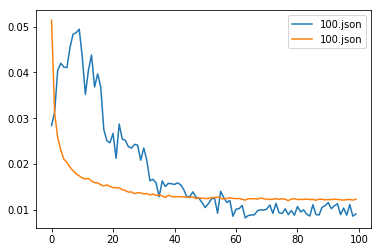

results/epoch/history_30.json


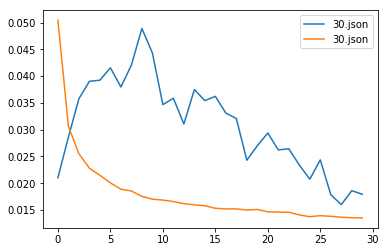

results/epoch/history_60.json


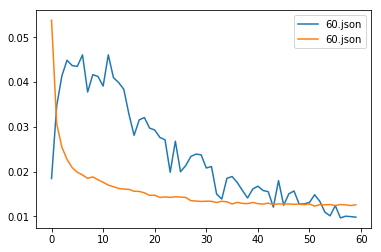

In [23]:
histFiles = os.listdir(dir_path)
for histFile in histFiles:
    if histFile.startswith('history'):
        jname = dir_path + histFile.split('.')[0] + '.json'
        print (jname)
        json_file = open(jname, 'r')
        loaded_model_json = json.load(json_file)
        json_file.close()
        output = loaded_model_json['val_mean_absolute_error']
        output_main = loaded_model_json['mean_absolute_error']
        plt.plot(output, label=histFile.split('_')[1])
        plt.plot(output_main, label=histFile.split('_')[1])
        plt.legend()
        plt.show()

In [25]:
clx = [ 'month','hour','dow','device_id','device_speed','meadianv','speed_2','INRIX_speed']
cnt = -1
neurons=[50,100,250,500];epoch=100;dropout=0.2;batch_size=200
dir_path = 'results/neuron/'
if not(os.path.isdir(dir_path)):
    os.makedirs(dir_path)
for neuron in neurons:
    cnt+=1
    new_col_data = merged_data[clx]
    for norm_col in clx: 
        new_col_data = norm_data_f(new_col_data, norm_col)
    values = new_col_data.values
    [train_X,train_y,test_X,test_y] = split_train_test(values)
    [model, history] = LSTM_MODEL (epoch, neuron, dropout, batch_size,train_X,train_y, test_X, test_y )
    save_model (dir_path, model,history,neuron)
    print('model ' + str(cnt) + ' completed ....')

C:\ProgramData\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(348109, 1, 7) (348109,) (174055, 1, 7) (174055,)
Train on 348109 samples, validate on 174055 samples
Epoch 1/100
10s - loss: 0.0627 - mean_absolute_error: 0.0627 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 2/100
10s - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 3/100
10s - loss: 0.0256 - mean_absolute_error: 0.0256 - val_loss: 0.0462 - val_mean_absolute_error: 0.0462
Epoch 4/100
10s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0488 - val_mean_absolute_error: 0.0488
Epoch 5/100
10s - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512
Epoch 6/100
10s - loss: 0.0196 - mean_absolute_error: 0.0196 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498
Epoch 7/100
10s - loss: 0.0190 - mean_absolute_error: 0.0190 - val_loss: 0.0429 - val_mean_absolute_error: 0.0429
Epoch 8/100
10s - loss: 0.0188 - mean_absolute_error: 0.0188 - val_loss: 0.0424 - val_mean_absolute_

10s - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0109 - val_mean_absolute_error: 0.0109
Epoch 73/100
10s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0116 - val_mean_absolute_error: 0.0116
Epoch 74/100
10s - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0131 - val_mean_absolute_error: 0.0131
Epoch 75/100
10s - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 76/100
10s - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137
Epoch 77/100
10s - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0115 - val_mean_absolute_error: 0.0115
Epoch 78/100
10s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0107 - val_mean_absolute_error: 0.0107
Epoch 79/100
10s - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0107 - val_mean_absolute_error: 0.0107
Epoch 80/100
10s - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0108 - val_mean_a

10s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 44/100
10s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0134 - val_mean_absolute_error: 0.0134
Epoch 45/100
10s - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137
Epoch 46/100
10s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0106 - val_mean_absolute_error: 0.0106
Epoch 47/100
10s - loss: 0.0130 - mean_absolute_error: 0.0130 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 48/100
10s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 49/100
10s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0108 - val_mean_absolute_error: 0.0108
Epoch 50/100
10s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0158 - val_mean_absolute_error: 0.0158
Epoch 51/100
10s - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0092 - val_mean_a

11s - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0295 - val_mean_absolute_error: 0.0295
Epoch 15/100
11s - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 16/100
12s - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 17/100
12s - loss: 0.0158 - mean_absolute_error: 0.0158 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 18/100
11s - loss: 0.0167 - mean_absolute_error: 0.0167 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374
Epoch 19/100
11s - loss: 0.0158 - mean_absolute_error: 0.0158 - val_loss: 0.0230 - val_mean_absolute_error: 0.0230
Epoch 20/100
10s - loss: 0.0160 - mean_absolute_error: 0.0160 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 21/100
10s - loss: 0.0150 - mean_absolute_error: 0.0150 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306
Epoch 22/100
10s - loss: 0.0151 - mean_absolute_error: 0.0151 - val_loss: 0.0283 - val_mean_a

11s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 87/100
11s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0078 - val_mean_absolute_error: 0.0078
Epoch 88/100
11s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 89/100
11s - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 90/100
11s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 91/100
11s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 92/100
11s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0081 - val_mean_absolute_error: 0.0081
Epoch 93/100
11s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 94/100
11s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0094 - val_mean_a

12s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0114 - val_mean_absolute_error: 0.0114
Epoch 58/100
12s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0112 - val_mean_absolute_error: 0.0112
Epoch 59/100
12s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0120 - val_mean_absolute_error: 0.0120
Epoch 60/100
12s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 61/100
12s - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0100 - val_mean_absolute_error: 0.0100
Epoch 62/100
12s - loss: 0.0129 - mean_absolute_error: 0.0129 - val_loss: 0.0112 - val_mean_absolute_error: 0.0112
Epoch 63/100
12s - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0119 - val_mean_absolute_error: 0.0119
Epoch 64/100
12s - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0086 - val_mean_absolute_error: 0.0086
Epoch 65/100
12s - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0089 - val_mean_a

results/neuron/history_100.json


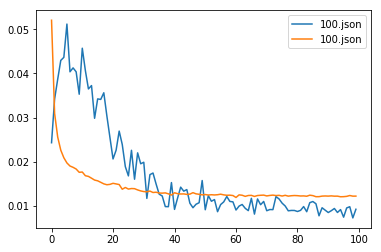

results/neuron/history_250.json


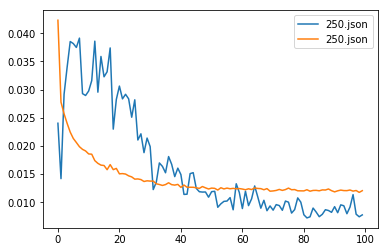

results/neuron/history_50.json


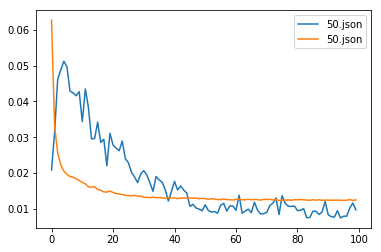

results/neuron/history_500.json


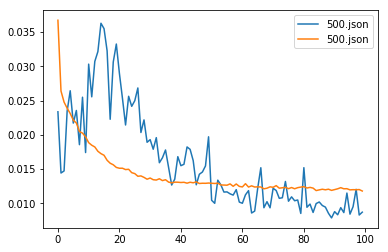

In [26]:
histFiles = os.listdir(dir_path)
for histFile in histFiles:
    if histFile.startswith('history'):
        jname = dir_path + histFile.split('.')[0] + '.json'
        print (jname)
        json_file = open(jname, 'r')
        loaded_model_json = json.load(json_file)
        json_file.close()
        output = loaded_model_json['val_mean_absolute_error']
        output_main = loaded_model_json['mean_absolute_error']
        plt.plot(output, label=histFile.split('_')[1])
        plt.plot(output_main, label=histFile.split('_')[1])
        plt.legend()
        plt.show()

In [27]:
clx = [ 'month','hour','dow','device_id','device_speed','meadianv','speed_2','INRIX_speed']
cnt = -1
neuron=100;epoch=100;dropout=0.2;batch_sizes=[50,100,200,500]
dir_path = 'results/batchsize/'
if not(os.path.isdir(dir_path)):
    os.makedirs(dir_path)
for batch_size in batch_sizes:
    cnt+=1
    new_col_data = merged_data[clx]
    for norm_col in clx: 
        new_col_data = norm_data_f(new_col_data, norm_col)
    values = new_col_data.values
    [train_X,train_y,test_X,test_y] = split_train_test(values)
    [model, history] = LSTM_MODEL (epoch, neuron, dropout, batch_size,train_X,train_y, test_X, test_y )
    save_model (dir_path, model,history,batch_size)
    print('model ' + str(cnt) + ' completed ....')

C:\ProgramData\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(348109, 1, 7) (348109,) (174055, 1, 7) (174055,)
Train on 348109 samples, validate on 174055 samples
Epoch 1/100
42s - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437
Epoch 2/100
41s - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0523 - val_mean_absolute_error: 0.0523
Epoch 3/100
41s - loss: 0.0178 - mean_absolute_error: 0.0178 - val_loss: 0.0709 - val_mean_absolute_error: 0.0709
Epoch 4/100
41s - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0631 - val_mean_absolute_error: 0.0631
Epoch 5/100
41s - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.0493 - val_mean_absolute_error: 0.0493
Epoch 6/100
41s - loss: 0.0156 - mean_absolute_error: 0.0156 - val_loss: 0.0548 - val_mean_absolute_error: 0.0548
Epoch 7/100
41s - loss: 0.0148 - mean_absolute_error: 0.0148 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458
Epoch 8/100
41s - loss: 0.0144 - mean_absolute_error: 0.0144 - val_loss: 0.0455 - val_mean_absolute_

41s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097
Epoch 73/100
41s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0115 - val_mean_absolute_error: 0.0115
Epoch 74/100
41s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097
Epoch 75/100
41s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 76/100
41s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 77/100
41s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 78/100
41s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0086 - val_mean_absolute_error: 0.0086
Epoch 79/100
41s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 80/100
41s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0097 - val_mean_a

20s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 44/100
21s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0100 - val_mean_absolute_error: 0.0100
Epoch 45/100
20s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 46/100
20s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0116 - val_mean_absolute_error: 0.0116
Epoch 47/100
20s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 48/100
20s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 49/100
21s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 50/100
20s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 51/100
20s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0099 - val_mean_a

10s - loss: 0.0157 - mean_absolute_error: 0.0157 - val_loss: 0.0257 - val_mean_absolute_error: 0.0257
Epoch 15/100
10s - loss: 0.0158 - mean_absolute_error: 0.0158 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 16/100
10s - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 17/100
10s - loss: 0.0151 - mean_absolute_error: 0.0151 - val_loss: 0.0251 - val_mean_absolute_error: 0.0251
Epoch 18/100
10s - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236
Epoch 19/100
10s - loss: 0.0150 - mean_absolute_error: 0.0150 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222
Epoch 20/100
10s - loss: 0.0147 - mean_absolute_error: 0.0147 - val_loss: 0.0273 - val_mean_absolute_error: 0.0273
Epoch 21/100
10s - loss: 0.0142 - mean_absolute_error: 0.0142 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 22/100
10s - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0239 - val_mean_a

10s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 87/100
10s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 88/100
10s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 89/100
10s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097
Epoch 90/100
10s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0100 - val_mean_absolute_error: 0.0100
Epoch 91/100
10s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 92/100
10s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 93/100
10s - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0098 - val_mean_absolute_error: 0.0098
Epoch 94/100
10s - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0115 - val_mean_a

4s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 58/100
4s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088
Epoch 59/100
4s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 60/100
4s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 61/100
4s - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 62/100
4s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0106 - val_mean_absolute_error: 0.0106
Epoch 63/100
4s - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097
Epoch 64/100
4s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 65/100
4s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0087 - val_mean_absolute_e

results/batchsize/history_100.json


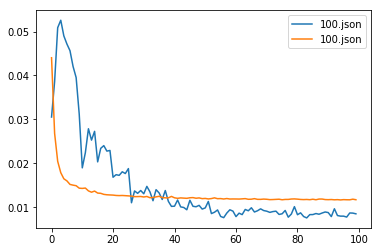

results/batchsize/history_200.json


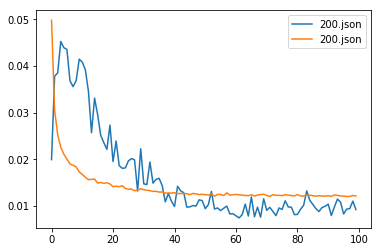

results/batchsize/history_50.json


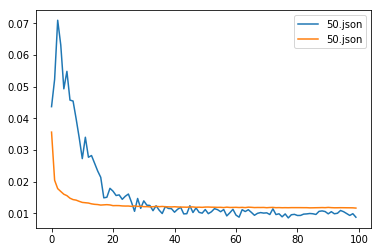

results/batchsize/history_500.json


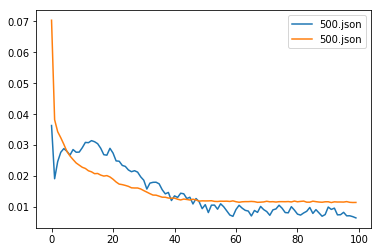

In [28]:
histFiles = os.listdir(dir_path)
for histFile in histFiles:
    if histFile.startswith('history'):
        jname = dir_path + histFile.split('.')[0] + '.json'
        print (jname)
        json_file = open(jname, 'r')
        loaded_model_json = json.load(json_file)
        json_file.close()
        output = loaded_model_json['val_mean_absolute_error']
        output_main = loaded_model_json['mean_absolute_error']
        plt.plot(output, label=histFile.split('_')[1])
        plt.plot(output_main, label=histFile.split('_')[1])
        plt.legend()
        plt.show()

In [9]:
def save_all_model (dir_path, model, history,batch_size,neuron, dropout, epoch, filename):
    history_dict = history.history; 
    fname = dir_path + '_' + filename + '_'+'history_' + str(batch_size) + str(neuron) +str(dropout) +str(epoch) +'.json'
    histfile = open(fname, 'w')
    json.dump(history_dict, histfile)
    histfile.close()
    model_json = model.to_json()
    mfname = dir_path + '_' + filename + '_'+'model_' + str(batch_size) + str(neuron) +str(dropout) +str(epoch) +'.json'
    mname = dir_path + '_' + filename + '_'+ 'model_' + str(batch_size) + str(neuron) +str(dropout) +str(epoch) +'.h5'
    with open(mfname, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(mname)
    json_file.close()
    
def LSTM_MODEL_shuffle (epochs, neurons, dropout, batch_size, train_X,train_y, test_X, test_y ):
    # default values: neurons=100;epochs=100;dropout=0.2;batch_size=200
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=True)
    return [model, history]

In [10]:
clx = [ 'month','hour','dow','device_id','device_speed','meadianv','speed_2','INRIX_speed']
cnt = -1
# neurons=[10,50,100,200];epochs=[150];dropouts=[0.02,0.2,0.4];batch_sizes=[500]
neurons=[200, 100, 10,50];epochs=[100, 30, 50];dropouts=[0.2];batch_sizes=[1000, 500, 200]
dir_path = 'results/all/'
training_data_folder = 'datasets/training_datasets/'
all_csv_files = os.listdir(training_data_folder)
for cur_tdata_file in all_csv_files:
    training_data_path = training_data_folder + cur_tdata_file
    filename = cur_tdata_file.split('.csv')[0]
    merged_data = pd.read_csv(training_data_path)
    if not(os.path.isdir(dir_path)):
        os.makedirs(dir_path)
    for batch_size in batch_sizes:
        for neuron in neurons:
            for dropout in dropouts:
                for epoch in epochs:
                    new_col_data = merged_data[clx]
                    for norm_col in clx: 
                        new_col_data = norm_data_f(new_col_data, norm_col)
                    values = new_col_data.values
                [train_X,train_y,test_X,test_y] = split_train_test(values)
                [model, history] = LSTM_MODEL_shuffle (epoch, neuron, dropout, batch_size,train_X,train_y, test_X, test_y )
                save_all_model (dir_path, model,history,batch_size,neuron, dropout, epoch, filename)
                print('model ' + str(cnt) + ' completed ....')

C:\ProgramData\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(348109, 1, 7) (348109,) (174055, 1, 7) (174055,)
Train on 348109 samples, validate on 174055 samples
Epoch 1/50
3s - loss: 0.0754 - mean_absolute_error: 0.0754 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248
Epoch 2/50
2s - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 3/50
2s - loss: 0.0293 - mean_absolute_error: 0.0293 - val_loss: 0.0142 - val_mean_absolute_error: 0.0142
Epoch 4/50
2s - loss: 0.0276 - mean_absolute_error: 0.0276 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 5/50
2s - loss: 0.0260 - mean_absolute_error: 0.0260 - val_loss: 0.0205 - val_mean_absolute_error: 0.0205
Epoch 6/50
2s - loss: 0.0245 - mean_absolute_error: 0.0245 - val_loss: 0.0112 - val_mean_absolute_error: 0.0112
Epoch 7/50
2s - loss: 0.0229 - mean_absolute_error: 0.0229 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097
Epoch 8/50
2s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127
Ep

2s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0067 - val_mean_absolute_error: 0.0067
Epoch 23/50
2s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 24/50
2s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 25/50
2s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0079 - val_mean_absolute_error: 0.0079
Epoch 26/50
2s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 27/50
2s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 28/50
2s - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088
Epoch 29/50
2s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 30/50
2s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0068 - val_mean_absolute_error: 0.

2s - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 45/50
2s - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 46/50
2s - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 47/50
2s - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0083 - val_mean_absolute_error: 0.0083
Epoch 48/50
2s - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 49/50
2s - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0081 - val_mean_absolute_error: 0.0081
Epoch 50/50
2s - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
model -1 completed ....
(348109, 1, 7) (348109,) (174055, 1, 7) (174055,)
Train on 348109 samples, validate on 174055 samples
Epoch 1/50
2s - loss: 0.1200 - mean_absolute_error: 0.1200 - val_loss: 0.0236 - val_mean_absolu

4s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065
Epoch 16/50
4s - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065
Epoch 17/50
4s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 18/50
4s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0067 - val_mean_absolute_error: 0.0067
Epoch 19/50
4s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0067 - val_mean_absolute_error: 0.0067
Epoch 20/50
4s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 21/50
4s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 22/50
4s - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065
Epoch 23/50
4s - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0065 - val_mean_absolute_error: 0.

4s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0072 - val_mean_absolute_error: 0.0072
Epoch 38/50
4s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 39/50
4s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 40/50
4s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0071 - val_mean_absolute_error: 0.0071
Epoch 41/50
4s - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 42/50
4s - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0072 - val_mean_absolute_error: 0.0072
Epoch 43/50
4s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0073 - val_mean_absolute_error: 0.0073
Epoch 44/50
4s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 45/50
4s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0082 - val_mean_absolute_error: 0.

4s - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 9/50
4s - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 10/50
4s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 11/50
4s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 12/50
4s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 13/50
4s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0100 - val_mean_absolute_error: 0.0100
Epoch 14/50
4s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0078 - val_mean_absolute_error: 0.0078
Epoch 15/50
4s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 16/50
4s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0078 - val_mean_absolute_error: 0.0

11s - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0072 - val_mean_absolute_error: 0.0072
Epoch 31/50
12s - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0072 - val_mean_absolute_error: 0.0072
Epoch 32/50
11s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0106 - val_mean_absolute_error: 0.0106
Epoch 33/50
11s - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 34/50
11s - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0081 - val_mean_absolute_error: 0.0081
Epoch 35/50
11s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065
Epoch 36/50
11s - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065
Epoch 37/50
11s - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065
Epoch 38/50
11s - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0073 - val_mean_absolute_

(348109, 1, 7) (348109,) (174055, 1, 7) (174055,)
Train on 348109 samples, validate on 174055 samples
Epoch 1/50
11s - loss: 0.1044 - mean_absolute_error: 0.1044 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 2/50
10s - loss: 0.0278 - mean_absolute_error: 0.0278 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 3/50
10s - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 4/50
10s - loss: 0.0141 - mean_absolute_error: 0.0141 - val_loss: 0.0079 - val_mean_absolute_error: 0.0079
Epoch 5/50
10s - loss: 0.0137 - mean_absolute_error: 0.0137 - val_loss: 0.0083 - val_mean_absolute_error: 0.0083
Epoch 6/50
10s - loss: 0.0136 - mean_absolute_error: 0.0136 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 7/50
10s - loss: 0.0135 - mean_absolute_error: 0.0135 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 8/50
10s - loss: 0.0135 - mean_absolute_error: 0.0135 - val_loss: 0.0080 - val_mean_absolute_error: 0

10s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 22/50
11s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0078 - val_mean_absolute_error: 0.0078
Epoch 23/50
10s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 24/50
11s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0076 - val_mean_absolute_error: 0.0076
Epoch 25/50
11s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0072 - val_mean_absolute_error: 0.0072
Epoch 26/50
11s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 27/50
10s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 28/50
10s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 29/50
10s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0079 - val_mean_absolute_

2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 44/50
2s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 45/50
2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 46/50
2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 47/50
2s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 48/50
3s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0221 - val_mean_absolute_error: 0.0221
Epoch 49/50
2s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
Epoch 50/50
2s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
model -1 completed ....
(348102, 1, 7) (348102,) (174051, 1, 7) (174051,)
Train on 348102 samples, validate 

2s - loss: 0.0230 - mean_absolute_error: 0.0230 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182
Epoch 15/50
2s - loss: 0.0229 - mean_absolute_error: 0.0229 - val_loss: 0.0185 - val_mean_absolute_error: 0.0185
Epoch 16/50
2s - loss: 0.0229 - mean_absolute_error: 0.0229 - val_loss: 0.0196 - val_mean_absolute_error: 0.0196
Epoch 17/50
2s - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0190 - val_mean_absolute_error: 0.0190
Epoch 18/50
2s - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0193 - val_mean_absolute_error: 0.0193
Epoch 19/50
2s - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198
Epoch 20/50
2s - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204
Epoch 21/50
2s - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198
Epoch 22/50
2s - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0200 - val_mean_absolute_error: 0.

2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214
Epoch 37/50
2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 38/50
2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 39/50
2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217
Epoch 40/50
2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0219 - val_mean_absolute_error: 0.0219
Epoch 41/50
2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0220 - val_mean_absolute_error: 0.0220
Epoch 42/50
2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0219 - val_mean_absolute_error: 0.0219
Epoch 43/50
2s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222
Epoch 44/50
2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0223 - val_mean_absolute_error: 0.

4s - loss: 0.0236 - mean_absolute_error: 0.0236 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 8/50
4s - loss: 0.0230 - mean_absolute_error: 0.0230 - val_loss: 0.0190 - val_mean_absolute_error: 0.0190
Epoch 9/50
4s - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0193 - val_mean_absolute_error: 0.0193
Epoch 10/50
4s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 11/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 12/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0201 - val_mean_absolute_error: 0.0201
Epoch 13/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203
Epoch 14/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204
Epoch 15/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0202 - val_mean_absolute_error: 0.02

4s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0221 - val_mean_absolute_error: 0.0221
Epoch 30/50
4s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224
Epoch 31/50
4s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224
Epoch 32/50
4s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0225 - val_mean_absolute_error: 0.0225
Epoch 33/50
4s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228
Epoch 34/50
4s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 35/50
4s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244
Epoch 36/50
4s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0229 - val_mean_absolute_error: 0.0229
Epoch 37/50
4s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0232 - val_mean_absolute_error: 0.

model -1 completed ....
(348102, 1, 7) (348102,) (174051, 1, 7) (174051,)
Train on 348102 samples, validate on 174051 samples
Epoch 1/50
12s - loss: 0.0427 - mean_absolute_error: 0.0427 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 2/50
11s - loss: 0.0295 - mean_absolute_error: 0.0295 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
Epoch 3/50
11s - loss: 0.0265 - mean_absolute_error: 0.0265 - val_loss: 0.0247 - val_mean_absolute_error: 0.0247
Epoch 4/50
11s - loss: 0.0247 - mean_absolute_error: 0.0247 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 5/50
11s - loss: 0.0236 - mean_absolute_error: 0.0236 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191
Epoch 6/50
11s - loss: 0.0230 - mean_absolute_error: 0.0230 - val_loss: 0.0192 - val_mean_absolute_error: 0.0192
Epoch 7/50
11s - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0196 - val_mean_absolute_error: 0.0196
Epoch 8/50
11s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0218 - va

11s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0260 - val_mean_absolute_error: 0.0260
Epoch 22/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239
Epoch 23/50
10s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 24/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 25/50
10s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241
Epoch 26/50
10s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261
Epoch 27/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0256 - val_mean_absolute_error: 0.0256
Epoch 28/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0258 - val_mean_absolute_error: 0.0258
Epoch 29/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0264 - val_mean_absolute_

10s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353
Epoch 43/50
10s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0367 - val_mean_absolute_error: 0.0367
Epoch 44/50
10s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 45/50
10s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383
Epoch 46/50
10s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0404 - val_mean_absolute_error: 0.0404
Epoch 47/50
10s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 48/50
10s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0420 - val_mean_absolute_error: 0.0420
Epoch 49/50
11s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422
Epoch 50/50
11s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0427 - val_mean_absolute_

2s - loss: 0.0240 - mean_absolute_error: 0.0240 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194
Epoch 13/50
2s - loss: 0.0235 - mean_absolute_error: 0.0235 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180
Epoch 14/50
2s - loss: 0.0230 - mean_absolute_error: 0.0230 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166
Epoch 15/50
2s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166
Epoch 16/50
2s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167
Epoch 17/50
2s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167
Epoch 18/50
2s - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0172 - val_mean_absolute_error: 0.0172
Epoch 19/50
2s - loss: 0.0217 - mean_absolute_error: 0.0217 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167
Epoch 20/50
2s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0168 - val_mean_absolute_error: 0.

2s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 35/50
2s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0196 - val_mean_absolute_error: 0.0196
Epoch 36/50
2s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 37/50
2s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0184 - val_mean_absolute_error: 0.0184
Epoch 38/50
2s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0184 - val_mean_absolute_error: 0.0184
Epoch 39/50
2s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0185 - val_mean_absolute_error: 0.0185
Epoch 40/50
2s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187
Epoch 41/50
2s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188
Epoch 42/50
2s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0206 - val_mean_absolute_error: 0.

2s - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0260 - val_mean_absolute_error: 0.0260
Epoch 6/50
2s - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261
Epoch 7/50
2s - loss: 0.0285 - mean_absolute_error: 0.0285 - val_loss: 0.0221 - val_mean_absolute_error: 0.0221
Epoch 8/50
2s - loss: 0.0253 - mean_absolute_error: 0.0253 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 9/50
2s - loss: 0.0233 - mean_absolute_error: 0.0233 - val_loss: 0.0171 - val_mean_absolute_error: 0.0171
Epoch 10/50
2s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197
Epoch 11/50
2s - loss: 0.0217 - mean_absolute_error: 0.0217 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 12/50
2s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 13/50
2s - loss: 0.0214 - mean_absolute_error: 0.0214 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173

5s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182
Epoch 28/50
5s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0185 - val_mean_absolute_error: 0.0185
Epoch 29/50
5s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180
Epoch 30/50
5s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182
Epoch 31/50
5s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0186 - val_mean_absolute_error: 0.0186
Epoch 32/50
5s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 33/50
5s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194
Epoch 34/50
5s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194
Epoch 35/50
5s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0188 - val_mean_absolute_error: 0.

4s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241
Epoch 50/50
4s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
model -1 completed ....
(348108, 1, 7) (348108,) (174054, 1, 7) (174054,)
Train on 348108 samples, validate on 174054 samples
Epoch 1/50
6s - loss: 0.1335 - mean_absolute_error: 0.1335 - val_loss: 0.0489 - val_mean_absolute_error: 0.0489
Epoch 2/50
4s - loss: 0.0643 - mean_absolute_error: 0.0643 - val_loss: 0.0396 - val_mean_absolute_error: 0.0396
Epoch 3/50
4s - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 4/50
4s - loss: 0.0286 - mean_absolute_error: 0.0286 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 5/50
4s - loss: 0.0250 - mean_absolute_error: 0.0250 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 6/50
4s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0167 - val_mean_absolute_er

4s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 21/50
4s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0185 - val_mean_absolute_error: 0.0185
Epoch 22/50
4s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 23/50
4s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0190 - val_mean_absolute_error: 0.0190
Epoch 24/50
4s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191
Epoch 25/50
4s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0196 - val_mean_absolute_error: 0.0196
Epoch 26/50
4s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 27/50
4s - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198
Epoch 28/50
4s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0207 - val_mean_absolute_error: 0.

11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352
Epoch 43/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0391 - val_mean_absolute_error: 0.0391
Epoch 44/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0409 - val_mean_absolute_error: 0.0409
Epoch 45/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0392 - val_mean_absolute_error: 0.0392
Epoch 46/50
11s - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0423 - val_mean_absolute_error: 0.0423
Epoch 47/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0409 - val_mean_absolute_error: 0.0409
Epoch 48/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0408 - val_mean_absolute_error: 0.0408
Epoch 49/50
11s - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0396 - val_mean_absolute_error: 0.0396
Epoch 50/50
11s - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0431 - val_mean_absolute_

11s - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0201 - val_mean_absolute_error: 0.0201
Epoch 13/50
11s - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191
Epoch 14/50
11s - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0200 - val_mean_absolute_error: 0.0200
Epoch 15/50
11s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0190 - val_mean_absolute_error: 0.0190
Epoch 16/50
11s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197
Epoch 17/50
11s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 18/50
11s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 19/50
11s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 20/50
11s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0201 - val_mean_absolute_

11s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308
Epoch 34/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 35/50
11s - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362
Epoch 36/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373
Epoch 37/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374
Epoch 38/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 39/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381
Epoch 40/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0394 - val_mean_absolute_error: 0.0394
Epoch 41/50
11s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0395 - val_mean_absolute_

2s - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 5/50
2s - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 6/50
2s - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236
Epoch 7/50
2s - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0196 - val_mean_absolute_error: 0.0196
Epoch 8/50
2s - loss: 0.0280 - mean_absolute_error: 0.0280 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237
Epoch 9/50
2s - loss: 0.0263 - mean_absolute_error: 0.0263 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187
Epoch 10/50
2s - loss: 0.0250 - mean_absolute_error: 0.0250 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187
Epoch 11/50
2s - loss: 0.0240 - mean_absolute_error: 0.0240 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 12/50
2s - loss: 0.0234 - mean_absolute_error: 0.0234 - val_loss: 0.0181 - val_mean_absolute_error: 0.0181


2s - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188
Epoch 27/50
2s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191
Epoch 28/50
2s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197
Epoch 29/50
2s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0193 - val_mean_absolute_error: 0.0193
Epoch 30/50
2s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191
Epoch 31/50
2s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0192 - val_mean_absolute_error: 0.0192
Epoch 32/50
2s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 33/50
2s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 34/50
2s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0194 - val_mean_absolute_error: 0.

2s - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231
Epoch 49/50
2s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 50/50
2s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233
model -1 completed ....
(348106, 1, 7) (348106,) (174053, 1, 7) (174053,)
Train on 348106 samples, validate on 174053 samples
Epoch 1/50
6s - loss: 0.0592 - mean_absolute_error: 0.0592 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 2/50
5s - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 3/50
5s - loss: 0.0307 - mean_absolute_error: 0.0307 - val_loss: 0.0229 - val_mean_absolute_error: 0.0229
Epoch 4/50
5s - loss: 0.0289 - mean_absolute_error: 0.0289 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 5/50
5s - loss: 0.0273 - mean_absolute_error: 0.0273 - val_loss: 0.0186 - val_mean_absolute_e

4s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206
Epoch 20/50
4s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204
Epoch 21/50
4s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206
Epoch 22/50
4s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206
Epoch 23/50
4s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 24/50
4s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217
Epoch 25/50
4s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 26/50
4s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224
Epoch 27/50
4s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0214 - val_mean_absolute_error: 0.

4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236
Epoch 42/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 43/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0230 - val_mean_absolute_error: 0.0230
Epoch 44/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0230 - val_mean_absolute_error: 0.0230
Epoch 45/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242
Epoch 46/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234
Epoch 47/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 48/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235
Epoch 49/50
4s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0236 - val_mean_absolute_error: 0.

11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203
Epoch 13/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0196 - val_mean_absolute_error: 0.0196
Epoch 14/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 15/50
11s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 16/50
11s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 17/50
11s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 18/50
11s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 19/50
11s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204
Epoch 20/50
11s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0212 - val_mean_absolute_

11s - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 34/50
11s - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0385 - val_mean_absolute_error: 0.0385
Epoch 35/50
11s - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0440 - val_mean_absolute_error: 0.0440
Epoch 36/50
11s - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0473 - val_mean_absolute_error: 0.0473
Epoch 37/50
11s - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0509 - val_mean_absolute_error: 0.0509
Epoch 38/50
11s - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0541 - val_mean_absolute_error: 0.0541
Epoch 39/50
11s - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521
Epoch 40/50
11s - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0559 - val_mean_absolute_error: 0.0559
Epoch 41/50
11s - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0601 - val_mean_absolute_

11s - loss: 0.0238 - mean_absolute_error: 0.0238 - val_loss: 0.0190 - val_mean_absolute_error: 0.0190
Epoch 4/50
11s - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204
Epoch 5/50
11s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 6/50
11s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198
Epoch 7/50
11s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206
Epoch 8/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204
Epoch 9/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 10/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 11/50
11s - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0226 - val_mean_absolute_error: